In [23]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import  matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from tokenizers import BertWordPieceTokenizer

import warnings 
warnings.simplefilter('ignore')

In [2]:
#data = pd.read_csv('../input/vneuron/preprocessed_texts_2700row.csv',index_col = [0])#

In [3]:
#data.intent = data.intent.map({'positive' :  1 , 'negative' : 0})

In [4]:
data = pd.read_csv('../input/vneuron/extra_train_data.csv')

In [5]:
data

,text,intent
0,والله جعفر القاسمي إنسان خلوق وحتى تفدليكو مقب...,1
1,تاعب ههه,0
2,محلاها وجيهة امان وجيهة رجعلنا ايامات مدام كنز...,1
3,Ti ch'ha lham !!! Mnin 9a3din yatel3ou ha lman...,0
4,7acha 5li9et rabbi,0
...,...,...
13660,صدقني ماسط و اسطك منه مثاماش.اقزززز.عامل روحاا...,0
13661,Hhhh mala jaw 😆😄😃😹😸,1
13662,Maset barcha,0
13663,كمشة امارك,0


In [6]:
EPOCHS = 5
BATCH_SIZE = 32 
MAX_LEN = 192
#MODEL = 'jplu/tf-xlm-roberta-large'
AUTO = tf.data.experimental.AUTOTUNE

In [7]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [8]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [9]:
#tokenizer = AutoTokenizer.from_pretrained(MODEL)

tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)

In [10]:
def build_model(transformer, max_len=512):

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy','AUC'])
    
    return model

In [11]:
#texts = regular_encode(data.text.values, tokenizer, maxlen=MAX_LEN)
texts = fast_encode(data.text.values.astype(str), fast_tokenizer, maxlen=MAX_LEN)

ys = data.intent.values

In [12]:
def create_train(x_train,y_train) :
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    return  train_dataset

def create_valid(x_valid,y_valid) :
    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_valid, y_valid))
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO)
    )
    
    return valid_dataset

def create_test(x_test) :
    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(x_test)
        .batch(BATCH_SIZE)
    )
    return test_dataset


#########################
Fold 1
#########################
Epoch 1/5
341/341 [==============================] - 140s 410ms/step - loss: 0.5725 - accuracy: 0.6698 - auc: 0.7492 - val_loss: 0.3652 - val_accuracy: 0.8375 - val_auc: 0.9184
Epoch 2/5
341/341 [==============================] - 138s 405ms/step - loss: 0.2893 - accuracy: 0.8759 - auc: 0.9489 - val_loss: 0.2429 - val_accuracy: 0.9056 - val_auc: 0.9646
Epoch 3/5
341/341 [==============================] - 137s 401ms/step - loss: 0.2069 - accuracy: 0.9160 - auc: 0.9738 - val_loss: 0.2479 - val_accuracy: 0.9126 - val_auc: 0.9698
Epoch 4/5
341/341 [==============================] - 138s 405ms/step - loss: 0.1577 - accuracy: 0.9396 - auc: 0.9842 - val_loss: 0.2243 - val_accuracy: 0.9246 - val_auc: 0.9732
Epoch 5/5
341/341 [==============================] - 138s 405ms/step - loss: 0.1206 - accuracy: 0.9556 - auc: 0.9903 - val_loss: 0.2228 - val_accuracy: 0.9276 - val_auc: 0.9743


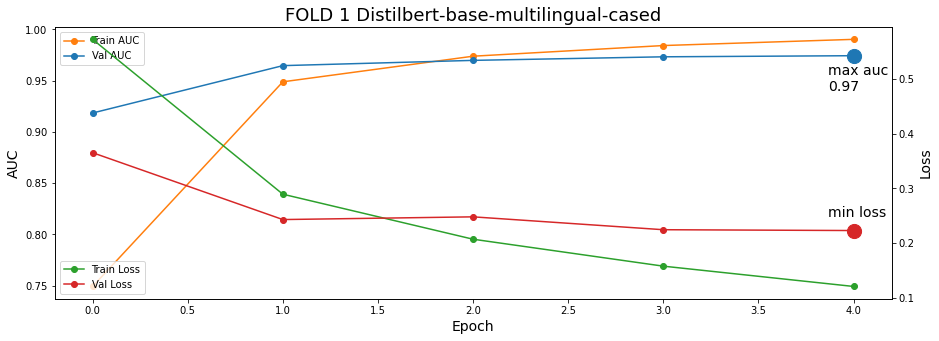


#########################
Fold 2
#########################
Epoch 1/5
341/341 [==============================] - 140s 410ms/step - loss: 0.5355 - accuracy: 0.7062 - auc: 0.7940 - val_loss: 0.3521 - val_accuracy: 0.8412 - val_auc: 0.9308
Epoch 2/5
341/341 [==============================] - 139s 406ms/step - loss: 0.3155 - accuracy: 0.8627 - auc: 0.9387 - val_loss: 0.2515 - val_accuracy: 0.8950 - val_auc: 0.9619
Epoch 3/5
341/341 [==============================] - 137s 402ms/step - loss: 0.2311 - accuracy: 0.9066 - auc: 0.9669 - val_loss: 0.2885 - val_accuracy: 0.8968 - val_auc: 0.9688
Epoch 4/5
341/341 [==============================] - 138s 405ms/step - loss: 0.1910 - accuracy: 0.9264 - auc: 0.9767 - val_loss: 0.2511 - val_accuracy: 0.9115 - val_auc: 0.9728
Epoch 5/5
341/341 [==============================] - 138s 405ms/step - loss: 0.1497 - accuracy: 0.9425 - auc: 0.9853 - val_loss: 0.1969 - val_accuracy: 0.9297 - val_auc: 0.9771


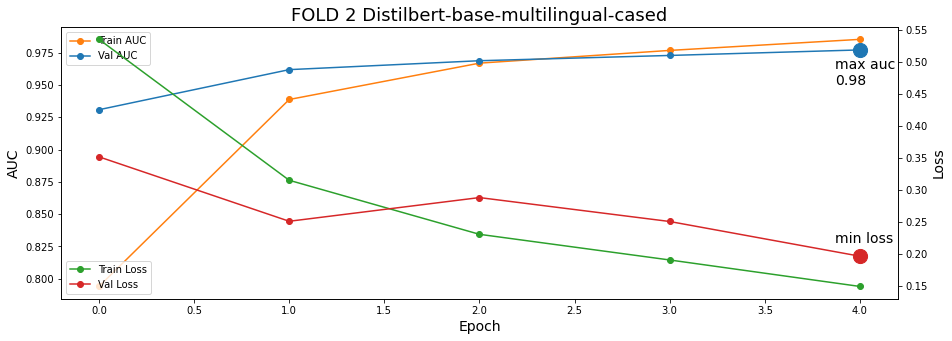


#########################
Fold 3
#########################
Epoch 1/5
341/341 [==============================] - 139s 408ms/step - loss: 0.5894 - accuracy: 0.6650 - auc: 0.7348 - val_loss: 0.3809 - val_accuracy: 0.8247 - val_auc: 0.9137
Epoch 2/5
341/341 [==============================] - 138s 405ms/step - loss: 0.3376 - accuracy: 0.8500 - auc: 0.9296 - val_loss: 0.2492 - val_accuracy: 0.8997 - val_auc: 0.9636
Epoch 3/5
341/341 [==============================] - 138s 406ms/step - loss: 0.2396 - accuracy: 0.9020 - auc: 0.9648 - val_loss: 0.2198 - val_accuracy: 0.9140 - val_auc: 0.9701
Epoch 4/5
341/341 [==============================] - 137s 401ms/step - loss: 0.1882 - accuracy: 0.9257 - auc: 0.9779 - val_loss: 0.2429 - val_accuracy: 0.9085 - val_auc: 0.9746
Epoch 5/5
341/341 [==============================] - 138s 404ms/step - loss: 0.1474 - accuracy: 0.9446 - auc: 0.9859 - val_loss: 0.2148 - val_accuracy: 0.9250 - val_auc: 0.9744


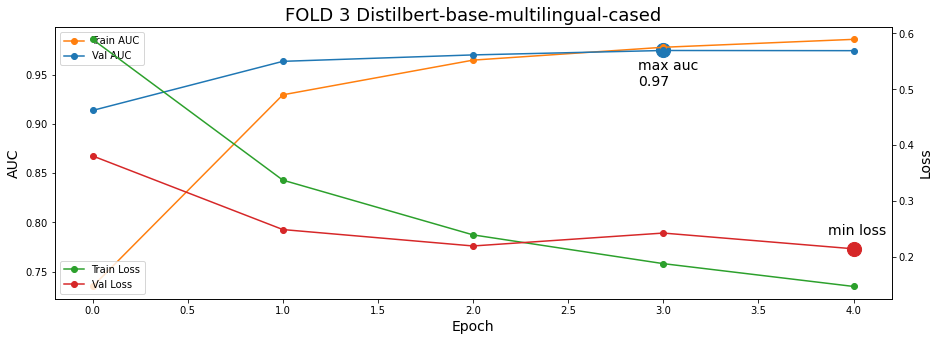


#########################
Fold 4
#########################
Epoch 1/5
341/341 [==============================] - 139s 409ms/step - loss: 0.5635 - accuracy: 0.6830 - auc: 0.7644 - val_loss: 0.3681 - val_accuracy: 0.8379 - val_auc: 0.9240
Epoch 2/5
341/341 [==============================] - 138s 404ms/step - loss: 0.3036 - accuracy: 0.8712 - auc: 0.9434 - val_loss: 0.2592 - val_accuracy: 0.8950 - val_auc: 0.9615
Epoch 3/5
341/341 [==============================] - 138s 405ms/step - loss: 0.2123 - accuracy: 0.9158 - auc: 0.9721 - val_loss: 0.2296 - val_accuracy: 0.9067 - val_auc: 0.9699
Epoch 4/5
341/341 [==============================] - 138s 405ms/step - loss: 0.1561 - accuracy: 0.9414 - auc: 0.9843 - val_loss: 0.2285 - val_accuracy: 0.9162 - val_auc: 0.9726
Epoch 5/5
341/341 [==============================] - 137s 400ms/step - loss: 0.1266 - accuracy: 0.9532 - auc: 0.9894 - val_loss: 0.2300 - val_accuracy: 0.9199 - val_auc: 0.9744


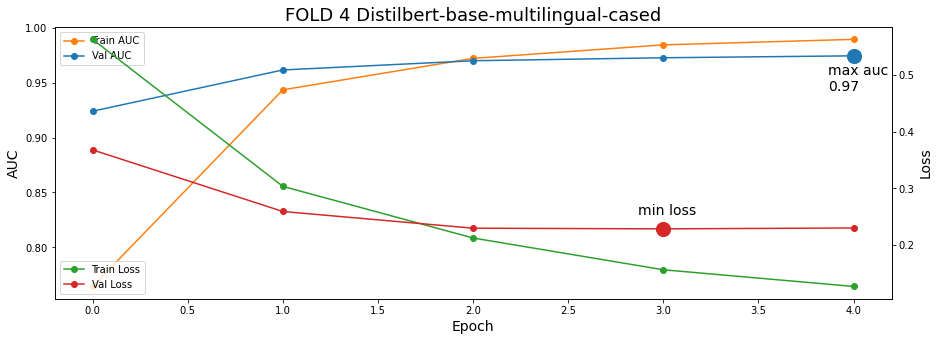


#########################
Fold 5
#########################
Epoch 1/5
341/341 [==============================] - 139s 409ms/step - loss: 0.5307 - accuracy: 0.7106 - auc: 0.7987 - val_loss: 0.3548 - val_accuracy: 0.8412 - val_auc: 0.9272
Epoch 2/5
341/341 [==============================] - 138s 404ms/step - loss: 0.2746 - accuracy: 0.8858 - auc: 0.9541 - val_loss: 0.2643 - val_accuracy: 0.8829 - val_auc: 0.9592
Epoch 3/5
341/341 [==============================] - 138s 405ms/step - loss: 0.2004 - accuracy: 0.9237 - auc: 0.9751 - val_loss: 0.2434 - val_accuracy: 0.9027 - val_auc: 0.9671
Epoch 4/5
341/341 [==============================] - 138s 404ms/step - loss: 0.1527 - accuracy: 0.9442 - auc: 0.9848 - val_loss: 0.2337 - val_accuracy: 0.9096 - val_auc: 0.9710
Epoch 5/5
341/341 [==============================] - 137s 401ms/step - loss: 0.1137 - accuracy: 0.9576 - auc: 0.9914 - val_loss: 0.2438 - val_accuracy: 0.9184 - val_auc: 0.9716


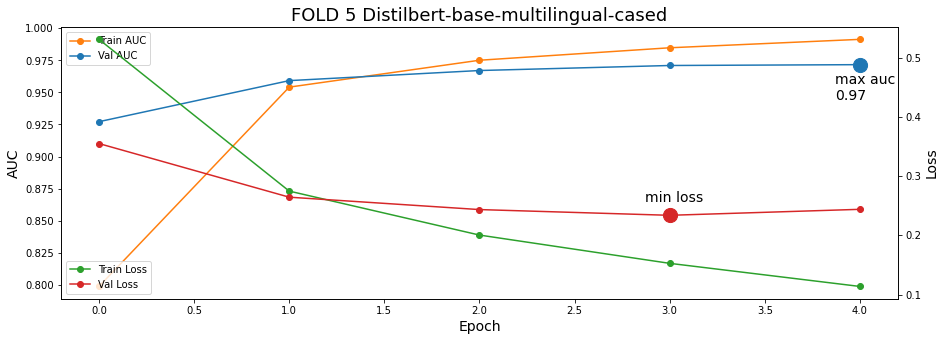

In [18]:
FOLDS = 5
SEED  = 42

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)

for fold,(train_indices,valid_indices) in enumerate(skf.split(texts,ys)) :
    print() ; print('#'*25)
    print('Fold' , fold+1)
    print('#'*25)
    
    #transformer_layer = TFAutoModel.from_pretrained(MODEL)
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
    
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
    
    n_steps = train_indices.shape[0] // BATCH_SIZE
    history = model.fit(
    create_train(texts[train_indices],ys[train_indices]),
    steps_per_epoch=n_steps,
    validation_data=create_valid(texts[valid_indices],ys[valid_indices]),
    epochs=EPOCHS,
    callbacks =  [sv]    
    )
    
    
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(EPOCHS),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(EPOCHS),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(EPOCHS),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(EPOCHS),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('FOLD %i Distilbert-base-multilingual-cased'%
                (fold+1),size=18)
    plt.legend(loc=3)
    plt.show()  

# Testing : 

In [19]:
test = pd.read_csv('../input/vneuron/extra_test_data.csv')

test_texts = fast_encode(test.text.values.astype(str), fast_tokenizer, maxlen=MAX_LEN)

test_ys = test.intent.values

In [20]:
results = model.predict(create_test(test_texts))
for i,result in enumerate(results) :
    if result > 0.5 :
        results[i] = 1
    else :
        results[i] = 0

In [21]:
confusion_matrix(test_ys, results)

array([[1581,  119],
       [ 137, 1563]])

In [24]:
print(classification_report(test_ys, results))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1700
           1       0.93      0.92      0.92      1700

    accuracy                           0.92      3400
   macro avg       0.92      0.92      0.92      3400
weighted avg       0.92      0.92      0.92      3400



In [28]:
all_ids = []
encs = fast_tokenizer.encode_batch(['j adore ','khedmtkom behyaa barcha','service khayeb'])
all_ids.extend([enc.ids for enc in encs])


test_data = create_test(np.array(all_ids))

predictions = model.predict(test_data)
#print(predictions*10)
for prediction in predictions :
    print(prediction)

[0.9857603]
[0.9914989]
[0.04848995]


#  Wrong Predictions : 

In [29]:
for i,prediction in enumerate(results) :
    if prediction != test_ys[i] :
        print(test['text'][i])

راجل كبير وفاة فلوسو
Yezziw ble t7in ???
Irhabi
جعفور من اولها ماهو فاهم شى ههههههههه حقها حكاية الملك ياسر ماسطة
ماحلاكم
علكة وعلة ...يشد ما يسيب..
أسفي على بلدي...هل أصبحنا في زمن نناقش ما حرمه الله
اول مرى ماشي في بالي فنان لاكن ظهر في الاخر فنان  كم انت كبير يا ابن الخضراء
بصراحة تصلح تمثل ادوار كوميدية اكثر من درامية
Myziena w mosrara
Nekeraha fi ill mosalesal awlede moufida akahaw
mala 3ab9rino ya rayan barvo
Ya go3er
el lekbiiiiiiiiiiiiiiir ekbiiiiiiiiiiiiiiiiiiiiiiiiiiiiiir
راجل كبير وواطي
ما شاء الله عليه شكيب  الدرويش بصراحة صورة مشرفة للمثقف التونسي بغض النظر عن اختلافاتنا الفكرية معاه ، اليوم نقاشو مع ريني الطرابلسي أثبت وأنه كعبه عالي وأنه يغرّد أحيانا خارج السرب ، حتى اعتذاره كان متاع معلّم ...على الأقل خير من برشا منافقين اللي يتلونوا مع الأرياح ..شكيب مكسب لقناة الحوار واصل ، وباهي وجود لطفي وشكيب اختلاف وتناقض ولكن ما يجمعهم حب تونس
Khorda
na7thawi
Bidoun t3li9
Balti isim kbir yo93ed dima kbir ♡♥
عادي مش أول مرة تتقال كلمة بزولة في قناة حوار الدعارة قالتها قبل وحدة هوي

# Saving the model : 

In [ ]:
import pickle


# Save the Modle to file in the current working directory

Pkl_Filename = "pickled_model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

# Semi supervized Pseudo Labelling : 

In [ ]:
extra_data = pd.read_csv('../input/vneuron/oreedoo_data.csv')

In [ ]:
l = []
for i in range(len(extra_data)) : 
    l.append(str(extra_data['r'][i]))

In [ ]:
model.load_weights('fold-2.h5')

In [ ]:
all_ids = []
encs = fast_tokenizer.encode_batch(l)
all_ids.extend([enc.ids for enc in encs])


test_data = create_test(np.array(all_ids))

predictions = model.predict(test_data)
#print(predictions*10)
for prediction in predictions :
    print(prediction)

In [ ]:
to_use_label_1 = []
to_use_label_0 = []
for i,prediction in enumerate(predictions) :
    if prediction > 0.8 :
        to_use_label_1.append(i)
    if prediction < 0.001 :
        to_use_label_0.append(i)

In [ ]:
print('Added positive labels :',len(to_use_label_1))
print('Added negative labels :',len(to_use_label_0))

In [ ]:
print('Added Positive examples :')
for i in to_use_label_1 :
    print(extra_data['r'][i])   

In [ ]:
print('Added Negative examples :')
for i in to_use_label_0 :
    print(extra_data['r'][i]) 